In [79]:
import math
import pandas as pd
import os

from biopandas.pdb import PandasPdb
import numpy as np

import torch

from matplotlib import pyplot as plt
import scipy.spatial as spa
from tqdm import tqdm

In [80]:
# Input: expects 3xN matrix of points
# Returns such R, t so that rmsd(R @ A + t, B) is min
# Uses Kabsch algorithm (https://en.wikipedia.org/wiki/Kabsch_algorithm)
# R = 3x3 rotation matrix
# t = 3x1 column vector
# This already takes residue identity into account.
def rigid_transform_Kabsch_3D(A, B):
    assert A.shape[1] == B.shape[1]
    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")
    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")


    # find mean column wise: 3 x 1
    centroid_A = np.mean(A, axis=1, keepdims=True)
    centroid_B = np.mean(B, axis=1, keepdims=True)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ Bm.T

    # find rotation
    U, S, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        # print("det(R) < R, reflection detected!, correcting for it ...")
        SS = np.diag([1.,1.,-1.])
        R = (Vt.T @ SS) @ U.T
    assert math.fabs(np.linalg.det(R) - 1) < 1e-5

    t = -R @ centroid_A + centroid_B
    return R, t

In [81]:
def compute_rmsd(pred, true):
    return np.sqrt(np.mean(np.sum((pred - true) ** 2, axis=1)))

In [82]:
def get_rmsd_summary(rmsds):
    rmsds_np = np.array(rmsds)
    return {
        'mean': np.mean(rmsds_np),
        'median': np.median(rmsds_np),
        'std': np.std(rmsds_np),
        'lt1': 100 * (rmsds_np < 1.0).sum() / len(rmsds_np),
        'lt2': 100 * (rmsds_np < 2.0).sum() / len(rmsds_np),
        'lt5': 100 * (rmsds_np < 5.0).sum() / len(rmsds_np),
        'lt10': 100 * (rmsds_np < 10.0).sum() / len(rmsds_np)
    }

In [101]:
class RMSDComputer():
    def __init__(self):
        self.complex_rmsd_list = []
        self.ligand_rmsd_list = []
        self.receptor_rmsd_list = []
    
    def update_all_rmsd(self, ligand_coors_pred, receptor_coors_pred, ligand_coors_true, receptor_coors_true):
        complex_rmsd = self.update_complex_rmsd(ligand_coors_pred, receptor_coors_pred, ligand_coors_true, receptor_coors_true)
        ligand_rmsd = self.update_ligand_rmsd(ligand_coors_pred, receptor_coors_pred, ligand_coors_true, receptor_coors_true)
        return complex_rmsd, ligand_rmsd

    def update_complex_rmsd(self, ligand_coors_pred, receptor_coors_pred, ligand_coors_true, receptor_coors_true):
        complex_coors_pred = np.concatenate((ligand_coors_pred, receptor_coors_pred), axis=0)
        complex_coors_true = np.concatenate((ligand_coors_true, receptor_coors_true), axis=0)

        R,t = rigid_transform_Kabsch_3D(complex_coors_pred.T, complex_coors_true.T)
        complex_coors_pred_aligned = (R @ complex_coors_pred.T + t).T

        complex_rmsd = compute_rmsd(complex_coors_pred_aligned, complex_coors_true)
        self.complex_rmsd_list.append(complex_rmsd)

        return complex_rmsd

    def update_ligand_rmsd(self, ligand_coors_pred, receptor_coors_pred, ligand_coors_true, receptor_coors_true):
        if np.allclose(receptor_coors_pred, receptor_coors_true, rtol=1e-6):
            ligand_coors_pred_aligned = ligand_coors_pred
        else:
            R, t = rigid_transform_Kabsch_3D(receptor_coors_pred.T, receptor_coors_true.T)
            ligand_coors_pred_aligned = (R @ ligand_coors_pred.T + t).T
        
        ligand_rmsd = compute_rmsd(ligand_coors_pred_aligned, ligand_coors_true)
        self.ligand_rmsd_list.append(ligand_rmsd)
        
        return ligand_rmsd
    
    def summarize(self):
        ligand_rmsd_summarized = get_rmsd_summary(self.ligand_rmsd_list) if self.ligand_rmsd_list else None
        complex_rmsd_summarized = get_rmsd_summary(self.complex_rmsd_list)
        return ligand_rmsd_summarized, complex_rmsd_summarized

In [102]:
ground_truth_dir = f"/data/rsg/nlp/sdobers/ruslan/equidock_public/test_sets_pdb/dips_test_random_transformed/complexes/"

pdb_files = [f for f in os.listdir(ground_truth_dir) if 
             os.path.isfile(os.path.join(ground_truth_dir, f)) 
             and f.endswith('.pdb')
            and "_l_" in f]
pdb_files = sorted(pdb_files)

In [103]:
# len(pdb_files)
pdb_files[0]

'a9_1a95.pdb1_3.dill_l_b_COMPLEX.pdb'

In [104]:
def get_alphafold_result_pdb(pdb_file):
    alphafold_result = "/data/rsg/nlp/sdobers/ruslan/alphafold_results"
    return f"{alphafold_result}/{pdb_file.replace('.dill_l_b_COMPLEX.pdb', '')}/ranked_0.pdb"

In [105]:
get_alphafold_result_pdb(pdb_files[0])

'/data/rsg/nlp/sdobers/ruslan/alphafold_results/a9_1a95.pdb1_3/ranked_0.pdb'

In [106]:
def get_coords_from_df(df, chain, atoms_to_keep):
    df = df[df.chain_id == chain]
    df = df[df["atom_name"].apply(lambda atom_name: atom_name in atoms_to_keep)]
    return df[['x_coord', 'y_coord', 'z_coord']].to_numpy().squeeze().astype(np.float32)
    

In [107]:
def get_alphagfold_coords(pdb_file, atoms_to_keep):
    pdb_file = get_alphafold_result_pdb(pdb_file)
    ppdb_model = PandasPdb().read_pdb(pdb_file)
    df = ppdb_model.df['ATOM']
    return get_coords_from_df(df, 'A', atoms_to_keep), get_coords_from_df(df, 'B', atoms_to_keep)

In [108]:
def get_gt_coords(pdb_file, atoms_to_keep):
    ppdb_model = PandasPdb().read_pdb(pdb_file)
    df = ppdb_model.df['ATOM']
    df = df[df["atom_name"].apply(lambda atom_name: atom_name in atoms_to_keep)]
    return df[['x_coord', 'y_coord', 'z_coord']].to_numpy().squeeze().astype(np.float32)

In [109]:
atoms_to_keep = ("CA", )

In [149]:
pd.set_option('mode.chained_assignment', None) # Remove annoying warnings

meter = RMSDComputer()

Irmsd_meter = RMSDComputer()

all_crmsd = []
all_irmsd = []
all_lrmsd = []

num_test_files = 0

for pdb_file in tqdm(pdb_files):
    # print(pdb_file)
    ligand_gt_file = f"{ground_truth_dir}/{pdb_file}"
    receptor_gt_file = f"{ground_truth_dir}/{pdb_file.replace('_l_', '_r_')}"

    ligand_model_coords, receptor_model_coords = get_alphagfold_coords(pdb_file, atoms_to_keep)
    # assert len(receptor_model_coords) >= len(ligand_model_coords)

    ligand_gt_coords = get_gt_coords(ligand_gt_file, atoms_to_keep)
    receptor_gt_coords = get_gt_coords(receptor_gt_file, atoms_to_keep)

    if ligand_model_coords.shape[0] != ligand_gt_coords.shape[0]:
        print(pdb_file)
        print("ligand", ligand_model_coords.shape[0], ligand_gt_coords.shape[0])
        ligand_gt_coords = ligand_gt_coords[:-1]
        # continue
    if receptor_model_coords.shape[0] != receptor_gt_coords.shape[0]:
        print(pdb_file)
        print("receptor", receptor_model_coords.shape[0], receptor_gt_coords.shape[0])
        receptor_gt_coords = receptor_gt_coords[:-1]
        # continue

    ligand_receptor_distance = spa.distance.cdist(ligand_gt_coords, receptor_gt_coords)
    positive_tuple = np.where(ligand_receptor_distance < 8.)

    active_ligand = positive_tuple[0]
    active_receptor = positive_tuple[1]

    ligand_model_pocket_coors = ligand_model_coords[active_ligand, :]
    receptor_model_pocket_coors = receptor_model_coords[active_receptor, :]

    ligand_gt_pocket_coors = ligand_gt_coords[active_ligand, :]
    receptor_gt_pocket_coors = receptor_gt_coords[active_receptor, :]


    crmsd, lrmsd = meter.update_all_rmsd(np.array(ligand_model_coords), np.array(receptor_model_coords),
                      np.array(ligand_gt_coords), np.array(receptor_gt_coords))

    irmsd = Irmsd_meter.update_complex_rmsd(np.array(ligand_model_pocket_coors), np.array(receptor_model_pocket_coors),
                            np.array(ligand_gt_pocket_coors), np.array(receptor_gt_pocket_coors))

    all_crmsd.append(crmsd)
    all_lrmsd.append(lrmsd)
    all_irmsd.append(irmsd)
    
    num_test_files += 1

 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 65/100 [00:20<00:10,  3.24it/s]

p7_4p7s.pdb1_2.dill_l_b_COMPLEX.pdb
receptor 92 93


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 92/100 [00:28<00:02,  3.31it/s]

tn_3tnp.pdb1_2.dill_l_b_COMPLEX.pdb
ligand 269 270


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.16it/s]


In [150]:
meter.__class__ = RMSDComputer
Irmsd_meter.__class__ = RMSDComputer

In [151]:
lrmsd, crmsd = meter.summarize()
_, irmsd = Irmsd_meter.summarize()

In [152]:
print(f'Number of samples:\t\t{num_test_files}')
print()
print(f"Ligand RMSD median/mean:\t{lrmsd['median']:.3}/{lrmsd['mean']:.3} ± {lrmsd['std']:.3}")
print(f"Complex RMSD median/mean:\t{crmsd['median']:.3}/{crmsd['mean']:.3} ± {crmsd['std']:.3}")
print(f"Interface RMSD median/mean:\t{irmsd['median']:.3}/{irmsd['mean']:.3} ± {irmsd['std']:.3}")
print()
print(f"Ligand lt1/lt2/lt5/lt10:\t{lrmsd['lt1']:.3}%/{lrmsd['lt2']:.3}%/{lrmsd['lt5']:.3}%/{lrmsd['lt10']:.3}%")
print(f"Complex lt1/lt2/lt5/lt10:\t{crmsd['lt1']:.3}%/{crmsd['lt2']:.3}%/{crmsd['lt5']:.3}%/{crmsd['lt10']:.3}%")
print(f"Interface lt1/lt2/lt5/lt10:\t{irmsd['lt1']:.3}%/{irmsd['lt2']:.3}%/{irmsd['lt5']:.3}%/{irmsd['lt10']:.3}%")

Number of samples:		100

Ligand RMSD median/mean:	24.0/29.7 ± 30.0
Complex RMSD median/mean:	8.61/11.7 ± 11.1
Interface RMSD median/mean:	6.67/9.15 ± 10.9

Ligand lt1/lt2/lt5/lt10:	14.0%/31.0%/43.0%/45.0%
Complex lt1/lt2/lt5/lt10:	24.0%/39.0%/45.0%/52.0%
Interface lt1/lt2/lt5/lt10:	39.0%/45.0%/47.0%/58.0%


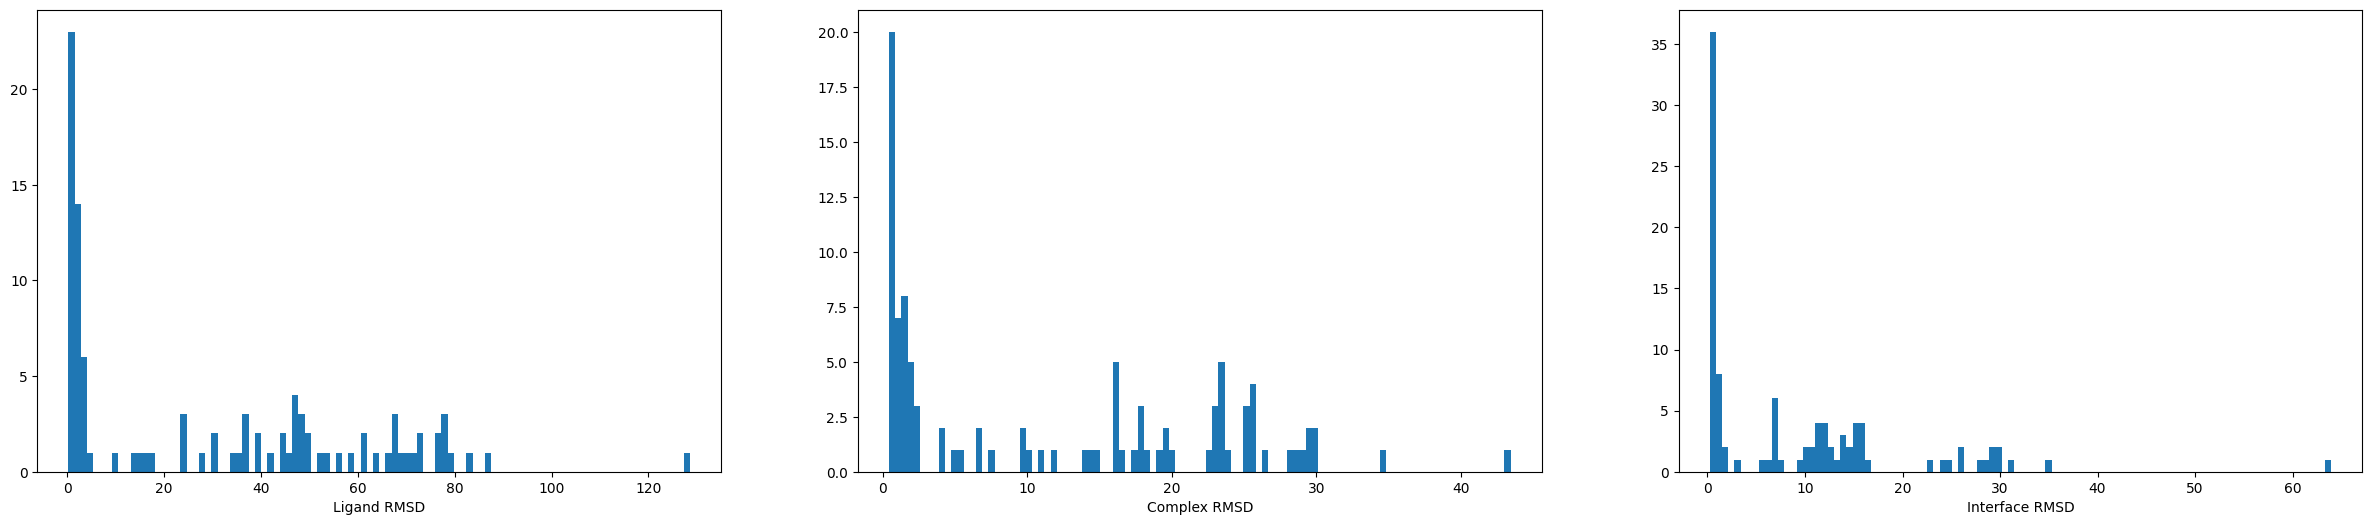

In [154]:
fig, ax = plt.subplots(1, 3, figsize = (30, 6))
_ = ax[0].hist(all_lrmsd, bins=100)
_ = ax[0].set(xlabel="Ligand RMSD")

_ = ax[1].hist(all_crmsd, bins=100)
_ = ax[1].set(xlabel="Complex RMSD")

_ = ax[2].hist(all_irmsd, bins=100)
_ = ax[2].set(xlabel="Interface RMSD")

plt.savefig("./alphafold.png")

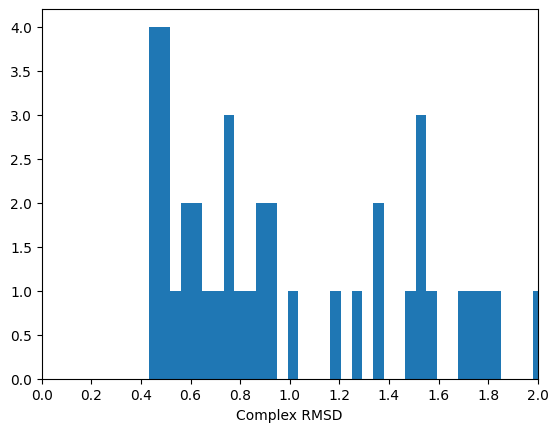

In [155]:
_ = plt.hist(all_crmsd, bins=1000)
_ = plt.xlabel("Complex RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

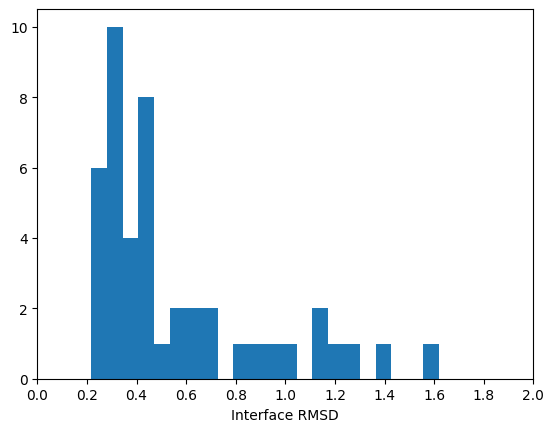

In [156]:
_ = plt.hist(all_irmsd, bins=1000)
_ = plt.xlabel("Interface RMSD")
_ = plt.xlim([0, 2])
_ = plt.xticks(np.linspace(0, 2, 11))

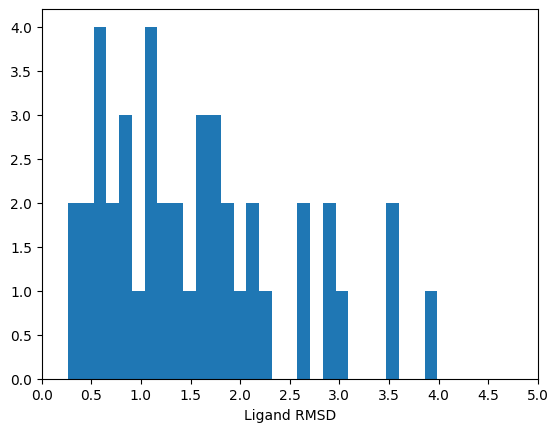

In [157]:
_ = plt.hist(all_lrmsd, bins=1000)
_ = plt.xlabel("Ligand RMSD")
_ = plt.xlim([0, 5])
_ = plt.xticks(np.linspace(0, 5, 11))